In [1]:
!pip install -q pyyaml h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17044070023677197214
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4745243395936753925
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15928269210
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12391096101647246169
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18159588674124374184
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
batch_size = 128
epoch = 8
NUM_CLASSES = 1066

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../data/train',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '../data/validation',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        '../data/test',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical')

Found 630277 images belonging to 1066 classes.
Found 88887 images belonging to 1066 classes.
Found 88887 images belonging to 1066 classes.


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# VGG 16

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

for layer in vgg16.layers[:2]:
    layer.trainable = False

x = vgg16.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(vgg16.input, predictions)

opt = Adam(0.0001)    
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [9]:
checkpointer_vgg = ModelCheckpoint(filepath='../saved_model/weights_vgg16v2.h5', 
                               verbose=1, save_best_only=True)

try:
    history_vgg = model.fit_generator(generator=train_generator,
                        validation_data=validation_generator,
                        use_multiprocessing=True,
                        callbacks=[checkpointer_vgg],
                        epochs=8,
                        workers=8,
                        verbose=1)
except KeyboardInterrupt:
        print('Output saved to: ../saved_model/weights_vgg16v2.h5')

Epoch 1/8
4924/4925 [============================>.] - ETA: 0s - loss: 1.3281 - categorical_accuracy: 0.7337
Epoch 00001: val_loss improved from inf to 0.58321, saving model to ../saved_model/weights_vgg16v2.h5
4925/4925 [==============================] - 1371s 278ms/step - loss: 1.3280 - categorical_accuracy: 0.7338 - val_loss: 0.5832 - val_categorical_accuracy: 0.8638
Epoch 2/8
4924/4925 [============================>.] - ETA: 0s - loss: 0.4068 - categorical_accuracy: 0.9021
Epoch 00002: val_loss improved from 0.58321 to 0.43034, saving model to ../saved_model/weights_vgg16v2.h5
4925/4925 [==============================] - 1362s 277ms/step - loss: 0.4068 - categorical_accuracy: 0.9021 - val_loss: 0.4303 - val_categorical_accuracy: 0.8980
Epoch 3/8
4924/4925 [============================>.] - ETA: 0s - loss: 0.2550 - categorical_accuracy: 0.9352
Epoch 00003: val_loss improved from 0.43034 to 0.33845, saving model to ../saved_model/weights_vgg16v2.h5
4925/4925 [========================

# ResNet 50

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# for layer in resnet.layers[:5]:
#     layer.trainable = False
    
out = Flatten()(resnet.output)
out = Dense(NUM_CLASSES, activation='softmax')(out)
model2 = Model(resnet.input, out)
model2.summary()

/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 64, 64, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler

checkpointer = ModelCheckpoint(filepath='../saved_model/weights_resnet50v3.h5', 
                               verbose=1, save_best_only=True)

def decay_scheduler(epoch_idx, lr):
    new_lr = lr
    if epoch_idx == 4:
        new_lr = lr/2
    if epoch_idx == 6:
        new_lr = lr/2
    return new_lr

lr_scheduler = LearningRateScheduler(decay_scheduler, verbose=1)

In [8]:
opt = Adam(0.0001)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['categorical_accuracy'])

try:
    history = model2.fit_generator(generator=train_generator,
                         validation_data=validation_generator,
                         epochs=8,
                         use_multiprocessing=True,
                         callbacks=[checkpointer, lr_scheduler],
                         workers=8,
                         verbose=1)
except KeyboardInterrupt:
        print('Output saved to: ../saved_model/weights_resnet50v3.h5')
    


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/8
4924/4925 [============================>.] - ETA: 0s - loss: 0.8203 - categorical_accuracy: 0.8287
Epoch 00001: val_loss improved from inf to 0.42904, saving model to ../saved_model/weights_resnet50v3.h5
4925/4925 [==============================] - 1453s 295ms/step - loss: 0.8202 - categorical_accuracy: 0.8288 - val_loss: 0.4290 - val_categorical_accuracy: 0.8954

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/8
4924/4925 [============================>.] - ETA: 0s - loss: 0.1177 - categorical_accuracy: 0.9676
Epoch 00002: val_loss improved from 0.42904 to 0.39267, saving model to ../saved_model/weights_resnet50v3.h5
4925/4925 [==============================] - 1421s 289ms/step - loss: 0.1177 - categorical_accuracy: 0.9676 - val_loss: 0.3927 - val_categorical_accuracy: 0.9086

Epoch 00003: LearningRateScheduler reducing learning rate to 9.9999997473

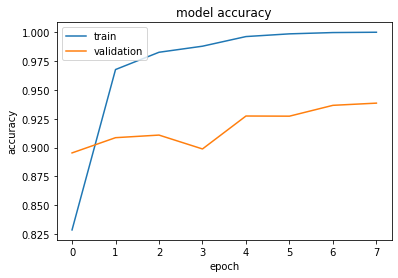

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

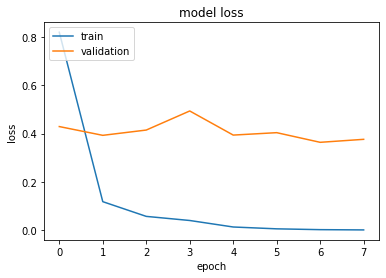

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()